<a href="https://colab.research.google.com/github/veronikavinnichenko/bum-s-bucket/blob/main/Vinnichenko_LAB4_mo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Лабораторная 4

В этой задаче мы рассмотрим, как работают методы уменьшения размерности данных и кластеризации. Параллельно мы еще раз попрактикуемся в решении задачи классификации.

Мы будем работать с набором данных Samsung Human Activity Recognition. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее о функциях можно узнать по ссылке https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones), также известен род деятельности человека с телефоном в кармане: шел, стоял, лежал, сидел или шел вверх, или вниз по лестнице.

Сначала сделаем вид, что вид деятельности нам неизвестен, и попробуем кластеризовать людей исключительно по имеющимся признакам. Затем решаем задачу определения вида физической активности как задачу классификации.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17


<ipython-input-1-3f8327c05096>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


In [2]:
!wget  -O 'X_train.txt' -q 'https://www.dropbox.com/scl/fi/61d589zshpj0a92xtef4c/X_train.txt?rlkey=aozwaa6i8a5eijyaxughc52rk&dl=0'
!wget  -O 'y_train.txt' -q 'https://www.dropbox.com/scl/fi/06m55z6m2sc2h99jju9rb/y_train.txt?rlkey=uo6i54o939ym5w4zjeprqkaqy&dl=0'
!wget  -O 'X_test.txt' -q 'https://www.dropbox.com/scl/fi/xo7lynpi183niopbl6d7p/X_test.txt?rlkey=3c3h3mbc69wdzyci3zq1cm7vq&dl=0'
!wget  -O 'y_test.txt' -q 'https://www.dropbox.com/scl/fi/w3dluvb2fv4zvri9zk0iy/y_test.txt?rlkey=18iap6tpqfh0h2dgdlfpvwu10&dl=0'

In [3]:
# измените путь до места, где лежат файлы, если необходимо
PATH_TO_SAMSUNG_DATA = "./"

In [4]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "y_train.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "X_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "y_test.txt")).astype(int)

In [5]:
# Проверяем размерность
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))


Для кластеризации нам не нужен целевой вектор, поэтому мы будем работать с комбинацией обучающей и тестовой выборок. Объедините X_train с X_test и y_train с y_test.

In [8]:
#X = pd.concat([X_train, X_test])
#y = pd.concat([y_train, y_test])

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим количество уникальных значений меток целевого класса.


In [12]:
np.unique(y)
n_classes = np.unique(y).size
n_classes

6

Описание метрик классов
1. – Идет
2. – Идет вверх
3. – Идет вниз
4. – Сидит
5. – Стоит
6. – Лежит

Масштабируйте образец с помощью StandardScaler с параметрами по умолчанию.


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Уменьшите количество измерений с помощью PCA, оставив столько компонентов, сколько необходимо для объяснения не менее 90% дисперсии исходных (масштабированных) данных. Используйте масштабированный набор данных и используйте <b>random_state=17  (константа RANDOM_STATE).</b>


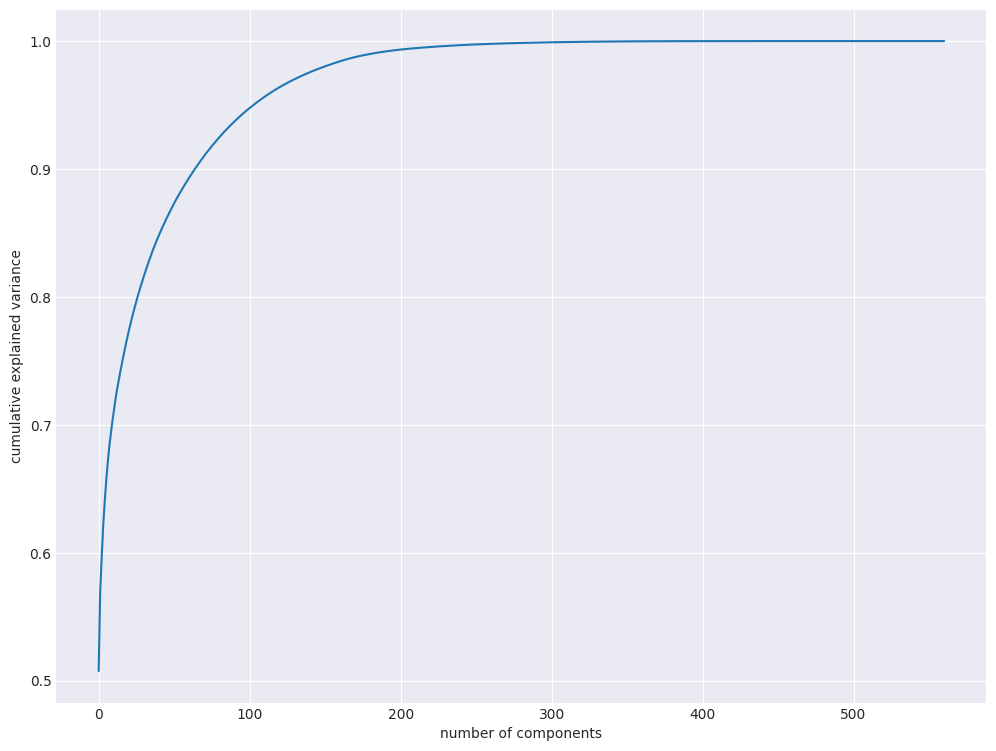

In [19]:
# ВАШ КОД ЗДЕСЬ
# pca =
# X_pca =

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [22]:
pca=PCA(.90, random_state = RANDOM_STATE)
X_pca=pca.fit_transform(X_scaled)

Вопрос 1:

Какое минимальное количество главных компонентов, необходимо для покрытия 90% дисперсии масштабированных  данных?

In [23]:
print('Number of components to explain 90% Variance is',pca.n_components_)

Number of components to explain 90% Variance is 65


Вопрос 2:
Какой процент дисперсии покрывается первой главной компонентой? Округлите до ближайшего процента.

In [28]:
print('Percent of variance the 1st pc explains is',round(pca.explained_variance_ratio_[0], 2)*100)

Percent of variance the 1st pc explains is 51.0


Визуализируйте данные в проекции на первые две главных компоненты.

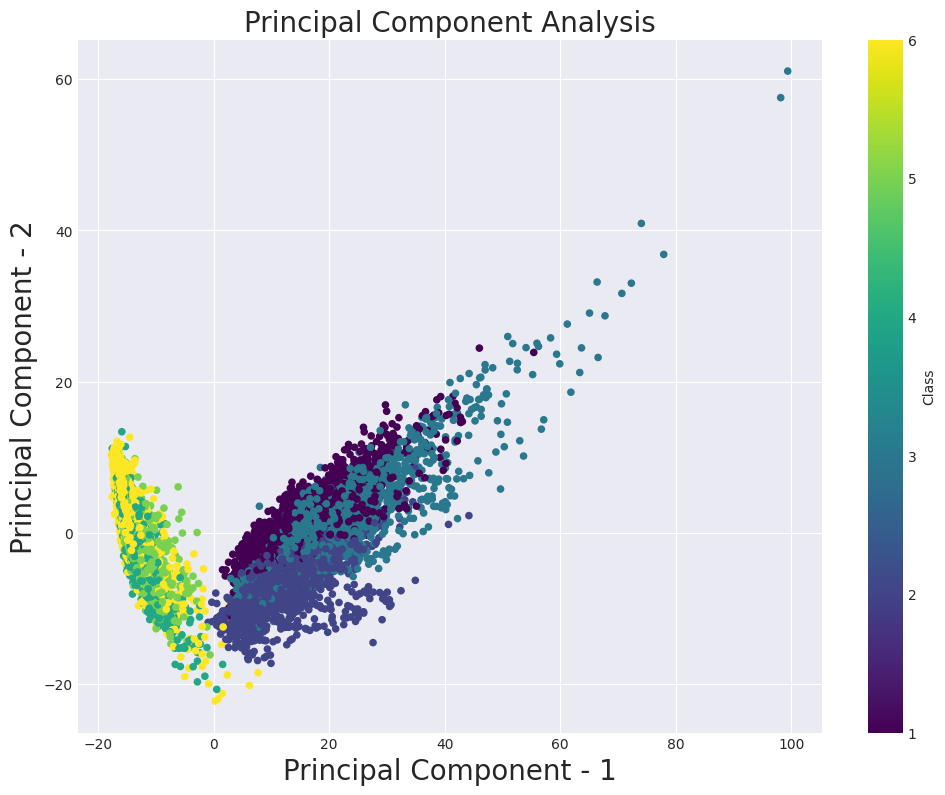

In [36]:
# ВАШ КОД ЗДЕСЬ
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
plt.colorbar(label = 'Class')
plt.show()

Вопрос 3:
Если все получилось правильно, вы увидите ряд кластеров, практически идеально отделенных друг от друга. Сколько получилось кластеров и Какие виды деятельности входят в эти кластеры?


ОТВЕТ:

На графике мы можем наблюдать **2** кластера, один из кластеров объединяет виды деятельности 1-3 (Идет, Идет вверх, Идет вниз), второй - 4-6 (Сидит, Стоит, Лежит).

Выполните кластеризацию с помощью метода KMeans, обучая модель на данных полученных после применения PCA.

Параметры:

- n_clusters = (сколько необходимо кластеров?)

- n_init = 100

- random_state = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры должны иметь значения по умолчанию.


In [37]:
kmeans = KMeans(n_clusters = 2, random_state = 17, n_init=100)
kmeans.fit(X_pca)

KMeans(n_clusters=2, n_init=100, random_state=17)

Визуализируйте данные в проекции на первые две главных компоненты. Раскрасьте точки в соответствии с полученными кластерами.

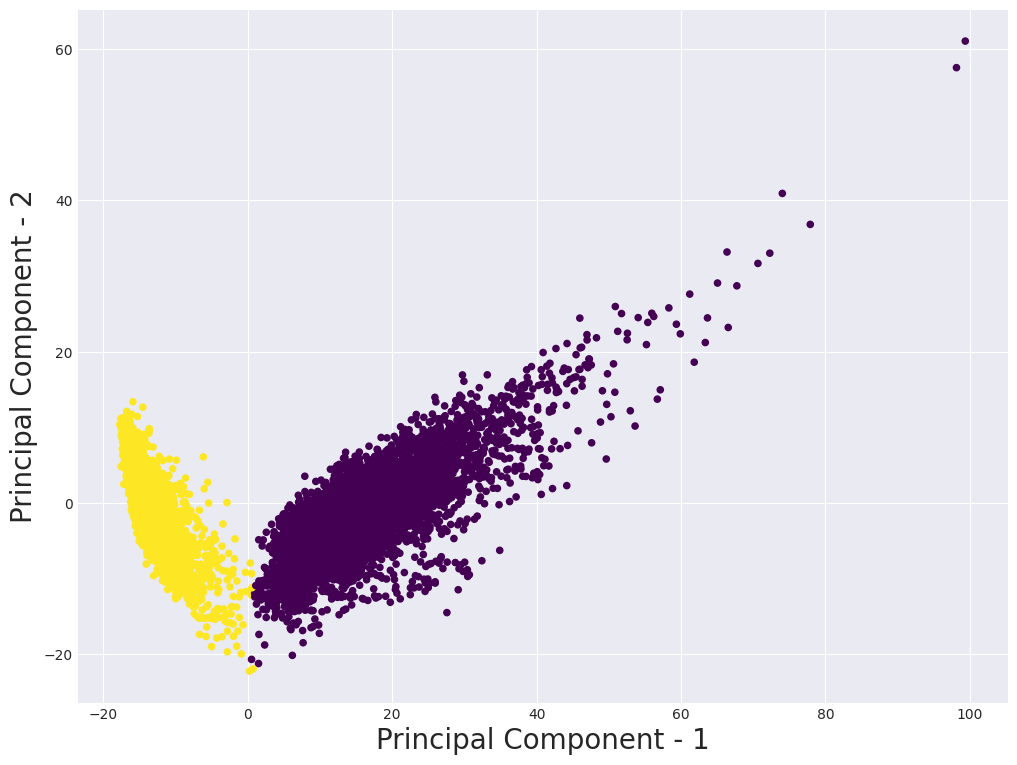

In [43]:
# ВАШ КОД ЗДЕСЬ
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, s=20, cmap='viridis')
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20);

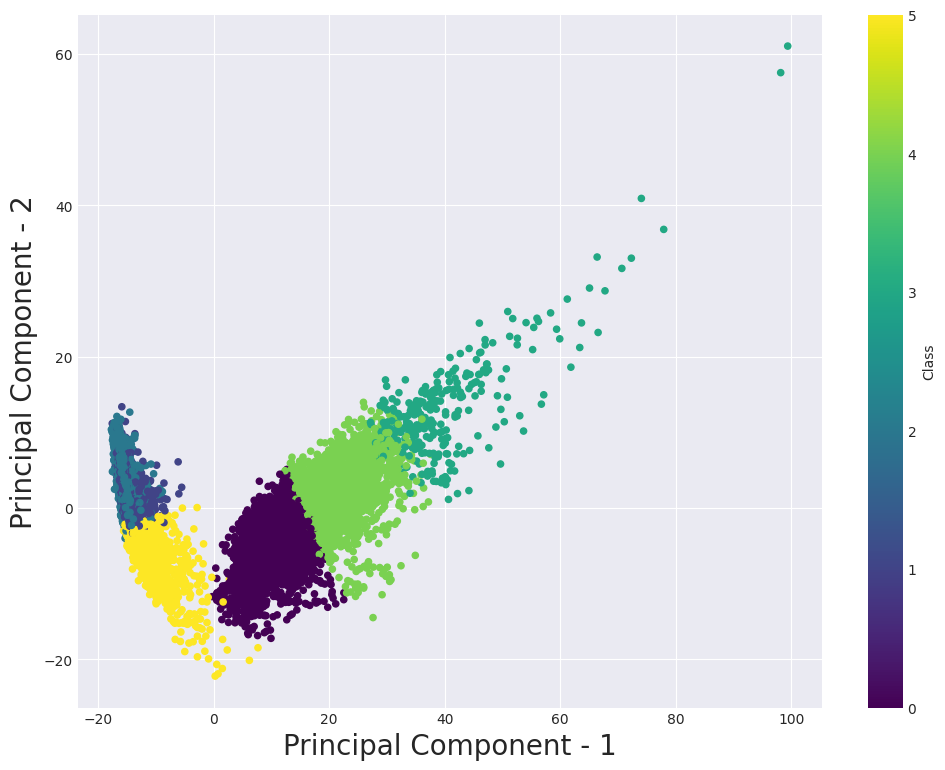

In [48]:
kmeans6 = KMeans(n_clusters=6, n_init=100, random_state=17)
kmeans6.fit(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans6.labels_, s=20, cmap='viridis');
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.colorbar(label = 'Class')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на каких видах деятельности алгоритм KMeans ошибается.

In [49]:
tab = pd.crosstab(y, kmeans6.labels_, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


Мы видим, что для каждого класса (т. е. каждого вида деятельности) существует несколько кластеров. Давайте посмотрим на максимальный процент объектов в классе, отнесенных к одному кластеру. Это будет простая метрика, характеризующая, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса «идет вниз» (1406 экземпляров), распределение кластеров таково:

кластер 1 – 900
кластер 3 – 500
кластер 6 - 6,
тогда такая доля будет 900/1406 ≈
  0,64.


Вопрос 4:
Какая деятельность лучше других отделена от остальных на основе метрики, описанной выше?

In [52]:
# ВАШ КОД ЗДЕСЬ
max_values = tab.drop('all',axis = 1).max(axis=1)
round(max_values / tab['all'] * 100, 2)

walking                  52.44
going up the stairs      80.38
going down the stairs    63.30
sitting                  69.50
standing                 70.51
laying                   80.14
all                      25.55
dtype: float64

ОТВЕТ:

going up the stairs

Видно, что kMeans не очень хорошо различает виды действий. Используйте метод локтя (Elbow Method), чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные, которые мы используем, такие же, как и раньше, меняем только n_clusters.

Визуализируете изменение inertia на графике

In [53]:
# # ВАШ КОД ЗДЕСЬ
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=17)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

<ipython-input-53-15ea3cb1ca8f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

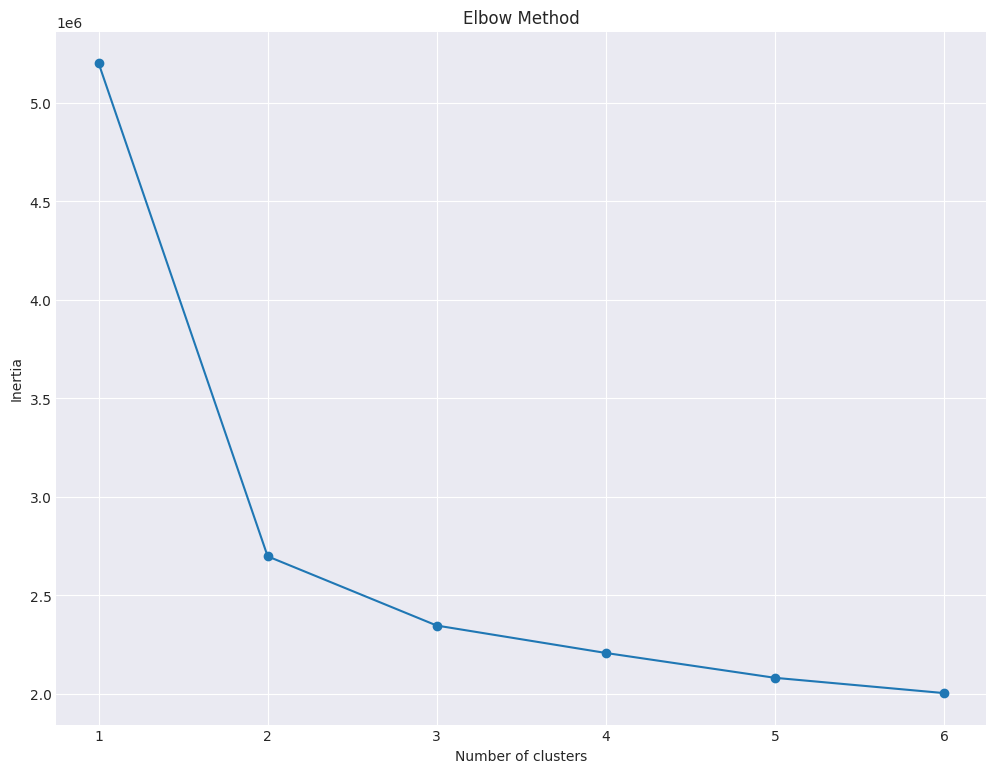

In [55]:
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Вопрос 5:
Сколько кластеров было бы оптимально выбрать по методу локтя?

ОТВЕТ:

Когда мы анализируем график, мы видим, что он быстро меняется в точке 2, создавая таким образом форму локтя. С этой точки график движется почти параллельно оси X. Таким образом, значение K, соответствующее 2, является оптимальным значением K или оптимальным количеством кластеров.

Если у нас мало кластеров это можно увидеть и на графике, но если кластеров много или тяжело определить "на глаз" по графику, то можно расчитать по формуле ниже

*(d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i]))*

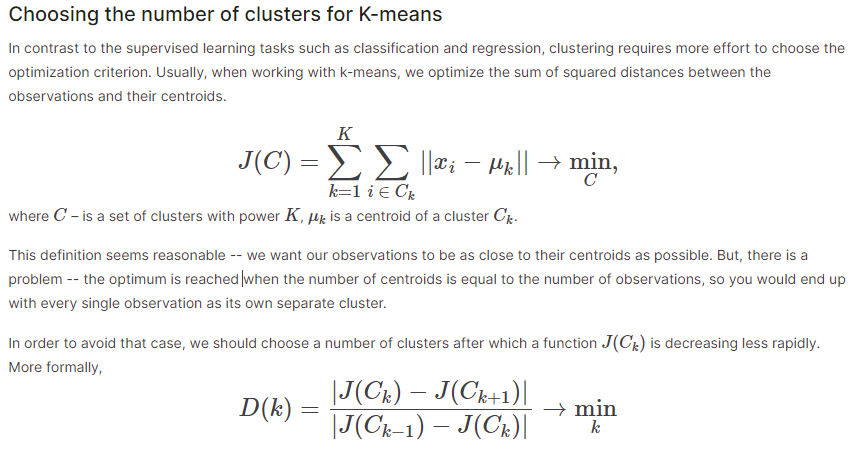



---



Попробуем другой алгоритм кластеризации - Agglomerative clustering.

In [56]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)


Рассчитайте Adjusted Rand Index (sklearn.metrics) для полученной кластеризации и для KMeans с параметрами из 4-го вопроса.


In [59]:
# ВАШ КОД ЗДЕСЬ
ARI_ag = metrics.adjusted_rand_score(y, ag.labels_)
ARI_kmeans = metrics.adjusted_rand_score(y, kmeans6.labels_)

print("Adjusted Rand Index Agglomerative clustering: ",round(ARI_ag, 2))
print("Adjusted Rand Index KMeans: ", round(ARI_kmeans, 2))

Adjusted Rand Index Agglomerative clustering:  0.49
Adjusted Rand Index KMeans:  0.42


Вопрос 6:
Выберите все правильные утверждения.

Утверждения:

- По данным ARI, KMeans справляется с кластеризацией хуже, чем Agglomerative clustering.
- Для ARI не имеет значения, какие теги присвоены кластеру, имеет значение только разбиение экземпляров на кластеры.
- В случае случайного разбиения на кластеры ARI будет близок к нулю.

 ОТВЕТ: все утверждения верны.



---



Можно заметить, что задача не очень хорошо решается, когда мы пытаемся обнаружить несколько кластеров (>2). Теперь давайте решим задачу классификации, учитывая, что данные размеченны.

Для классификации используйте sklearn.svm.LinearSVC.

Выберите гиперпараметр C для LinearSVC с помощью GridSearchCV.

Обучите новый StandardScaler на обучающем наборе (со всеми исходными функциями), примените масштабирование к тестовому набору.
В GridSearchCV укажите cv = 3.


In [60]:
# # ВАШ КОД ЗДЕСЬ
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [62]:
%%time
# ВАШ КОД ЗДЕСЬ
grid_search = GridSearchCV(svc, svc_params, cv=3)
grid_search.fit(X_train_scaled, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

CPU times: user 1min 17s, sys: 1.83 s, total: 1min 19s
Wall time: 1min 23s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [63]:
best_svc = grid_search.best_estimator_

Вопрос 7:

Какое значение гиперпараметра C было выбрано лучшим на основе перекрестной проверки?

In [67]:
grid_search.best_params_

{'C': 0.1}

In [64]:
y_predicted = best_svc.predict(X_test_scaled)

In [65]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab


,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


Вопрос 8:
Какой тип активности SVM хуже всего обнаруживает по метрике precision? И recall?


In [69]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       496
           2       0.98      0.97      0.98       471
           3       1.00      0.99      0.99       420
           4       0.96      0.87      0.91       491
           5       0.88      0.97      0.92       532
           6       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



- По метрике precision: SVM хуже всего обнаруживает 5 тип активности (стоит).
- По метрике recall: SVM хуже всего обнаруживает 4 тип активности (сидит).



---



Обучите снова LinearSVC, но добавьте PCA.

Используйте X_train_scaled и X_test_scaled.
Обучите PCA c теми же параметрами, что и раньше, на масштабированном обучающем наборе, примените масштабирование к тестовому набору.
Выберите гиперпараметр C посредством перекрестной проверки на обучающем наборе с PCA-преобразованием. Не забывайте использовать фиксированный <b>random_state=17  (константа RANDOM_STATE).</b>


Вы можете заметить насколько быстрее идет обучение

In [70]:
# # ВАШ КОД ЗДЕСЬ
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

pca = PCA(n_components=65, random_state=RANDOM_STATE)

X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

grid_search_pca = GridSearchCV(svc, svc_params, cv=3)
grid_search_pca.fit(X_train_scaled_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

Вопрос 9:

Какая разница между лучшей точностью (accuracy) перекрестной проверки в случае всех 561 исходной характеристик и во втором случае, когда применялся метод главных компонент? Округлите до ближайшего процента.


In [72]:
# # ВАШ КОД ЗДЕСЬ
round(grid_search.best_score_ - grid_search_pca.best_score_, 2) * 100


4.0